# AML Convolutional Neural Network for MNIST
Based on https://github.com/Atcold/pytorch-Deep-Learning


## Data and Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy, random


# set the PseudoRandom Generator Seeds for better reproducibility
# see here for more: https://pytorch.org/docs/stable/notes/randomness.html
torch.manual_seed(99)
random.seed(99)
numpy.random.seed(99)


# this 'device' will be used for training our model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### **Load the MNIST dataset**
Observe that we set `shuffle=True`, which means that data is randomized

In [4]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


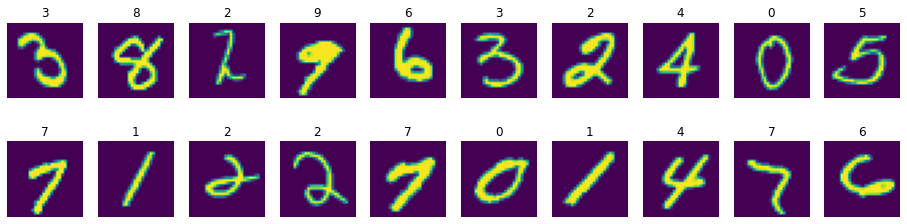

In [5]:
# show some training images
plt.figure(figsize=(16, 4))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(20):
    image = image_batch[i]
    label = label_batch[i].item()
    plt.subplot(2, 10, i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)

### Helper functions for training and testing

In [6]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

accuracy_list = []
# we pass a model object to this trainer, and it trains this model for one epoch
def train(epoch, model):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        output = model(data)
        #test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

## The Convolutional Network

In [7]:
class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(8*4*4, 200)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 8*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

### Train the Network

In [8]:
print("Training on ", device)
model_cnn = CNN(input_size, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 10):
    train(epoch, model_cnn)
    test(model_cnn)

Training on  cuda:0
Number of parameters: 66002
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314376
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.247057
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.543811
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.348373
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.439647
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.334617
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.239256
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.030815
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.211453
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.032946

Test set: Average loss: 0.1618, Accuracy: 9515/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.281891
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.091353
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.082387
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.112644
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.094412
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.074808
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.309685
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.043199
Tra

### Show some predictions of the test network

In [9]:
def visualize_pred(img, pred_prob, real_label):
    ''' Function for viewing an image and it's predicted classes.
    '''
    #pred_prob = pred_prob.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.numpy().squeeze())
    ax1.axis('off')
    pred_label = numpy.argmax(pred_prob)
    ax1.set_title([real_label, pred_label])
    
    ax2.barh(numpy.arange(10), pred_prob)
    ax2.set_aspect(0.1)
    ax2.set_yticks(numpy.arange(10))
    ax2.set_yticklabels(numpy.arange(10))
    ax2.set_title('Prediction Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()



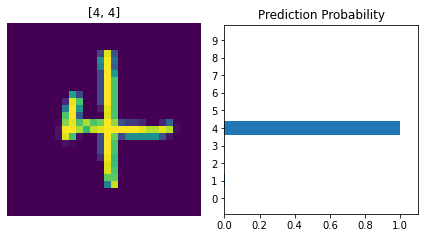

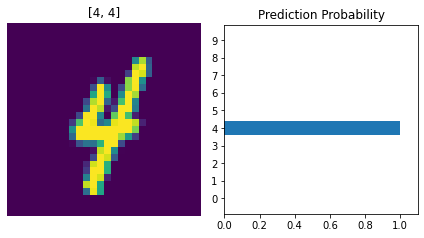

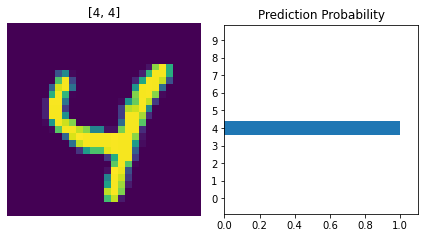

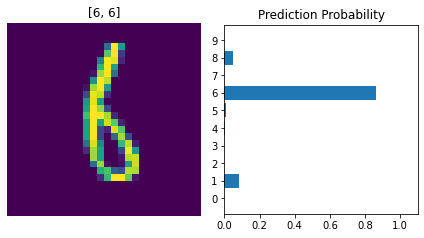

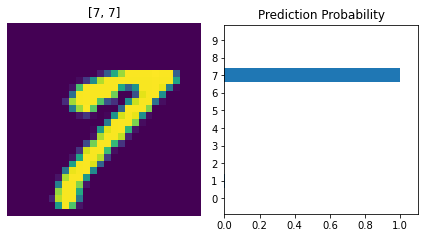

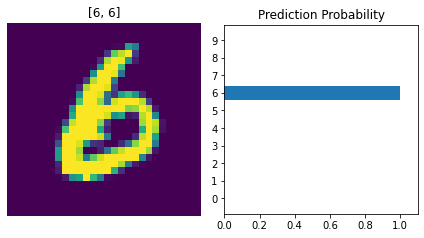

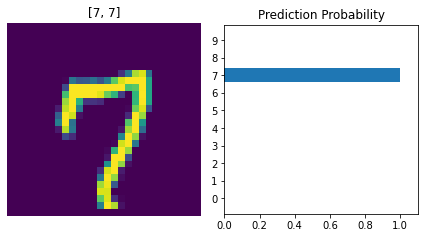

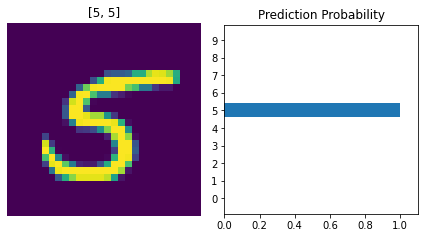

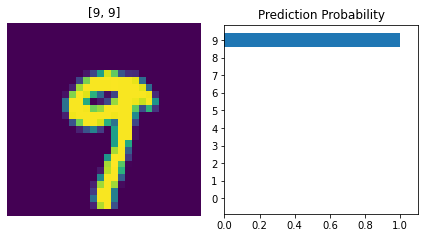

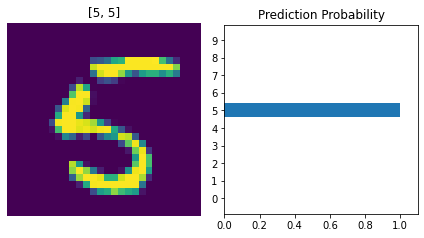

In [10]:
model_cnn.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

## Network with Dropout

In [11]:
class CNNDropout(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3,padding=0)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=6,padding=0)
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=6,padding=0)
        self.fc1 = nn.Linear(8*4*4, 200)
        self.do1 = nn.Dropout2d(p=0.8)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 8*4*4)
        x = self.fc1(x)
        x = self.do1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [12]:
print("Training on ", device)
model_2 = CNNDropout(input_size, output_size)
model_2.to(device)
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_2)))

for epoch in range(0, 10):
    model_2.train() # model in training mode. Turns on dropout, batch-norm etc during training
    train(epoch, model_2)
    model_2.eval() # model in evaluation mode. Turn off dropout, batch-norm etc during validation/testing
    test(model_2)

Training on  cuda:0
Number of parameters: 66002
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306069
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.758997
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.908702
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.667039
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.543066
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.635493
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.378995
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.287397
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.194406
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.298970

Test set: Average loss: 0.1656, Accuracy: 9474/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.419913
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.202465
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.164826
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.509709
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.188931
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.233923
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.360609
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.147047
Tra

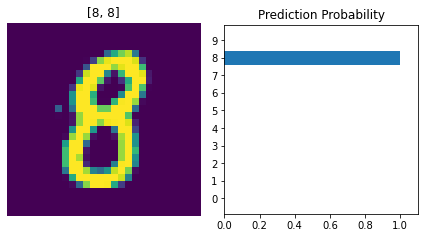

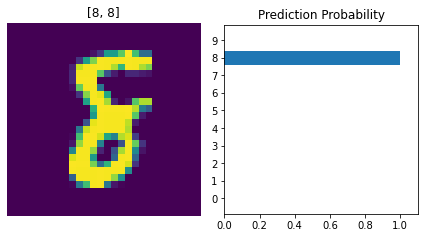

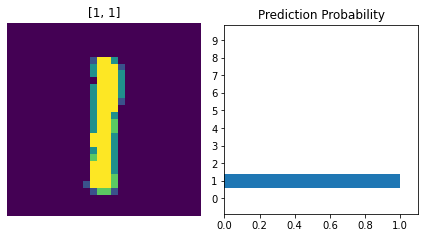

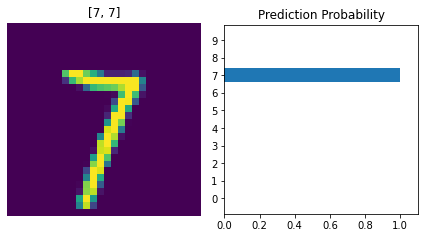

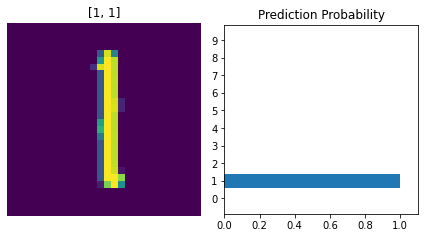

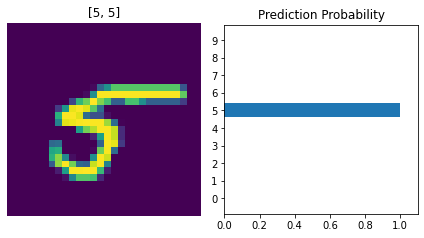

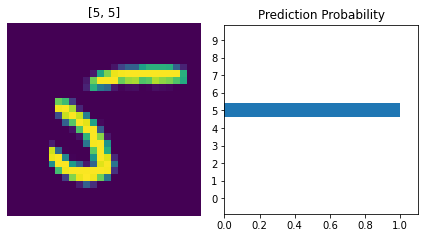

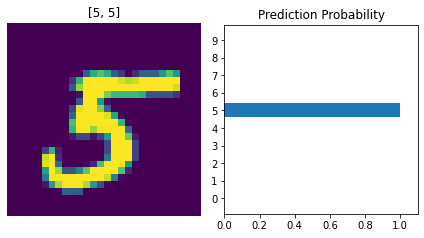

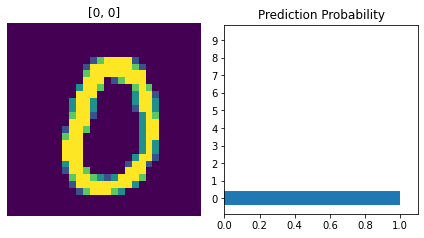

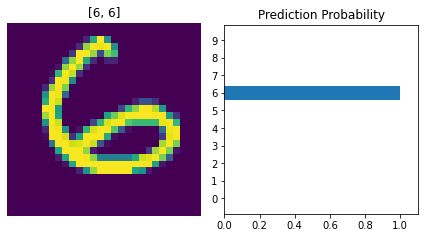

In [13]:
model_2.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))

# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_2(image_batch)
for i in range(10):
    img = image_batch[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img, pred_prob, real_label)

# Does the CNN use "Visual Information" ?

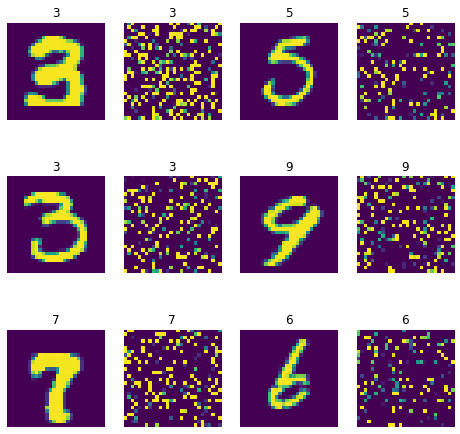

In [14]:
fixed_perm = torch.randperm(784) # Fix a permutation of the image pixels; We apply the same permutation to all images

# show some training images
plt.figure(figsize=(8, 8))

# fetch a batch of train images; RANDOM
image_batch, label_batch = next(iter(train_loader))

for i in range(6):
    image = image_batch[i]
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, fixed_perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    
    label = label_batch[i].item()
    plt.subplot(3,4 , 2*i + 1)
    #image, label = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.title(label)
    plt.subplot(3, 4, 2*i+2)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')
    plt.title(label)


In [15]:
accuracy_list = []

def scramble_train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def scramble_test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [16]:
print("Training on ", device)
model_cnn_3 = CNN(input_size, output_size)
model_cnn_3.to(device)
optimizer = optim.SGD(model_cnn_3.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn_3)))

for epoch in range(0, 10):
    scramble_train(epoch, model_cnn_3, fixed_perm)
    scramble_test(model_cnn_3, fixed_perm)

Training on  cuda:0
Number of parameters: 66002
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.311506
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.266764
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.184983
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.470032
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.816377
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.680872
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.736304
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.592037
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.344290
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.339610

Test set: Average loss: 0.3624, Accuracy: 8907/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.551571
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.334081
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.285482
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.352685
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.188578
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.412186
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.207640
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.190874
Tra

## Performance decreased from 99% to 96%

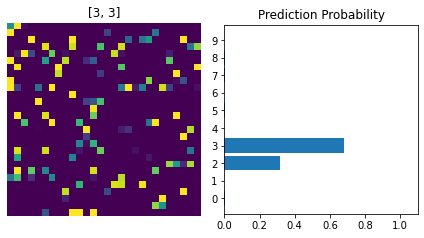

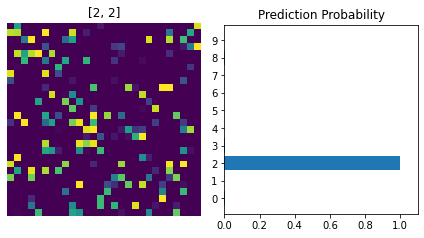

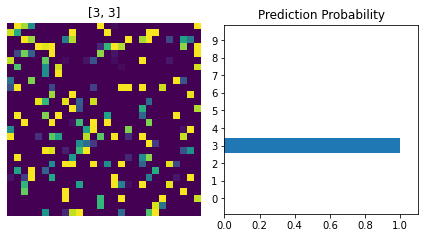

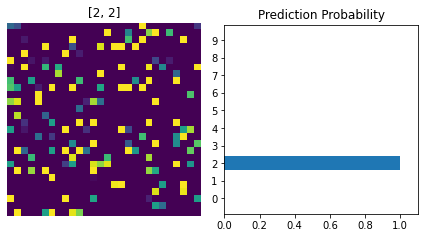

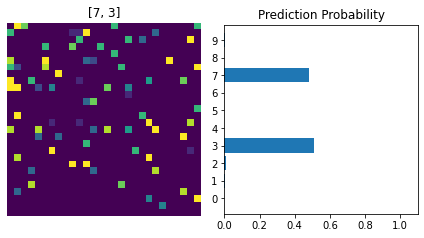

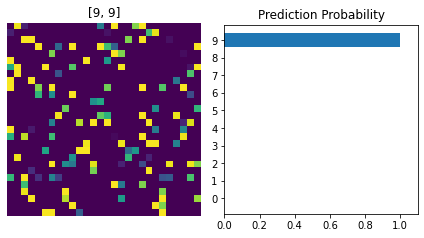

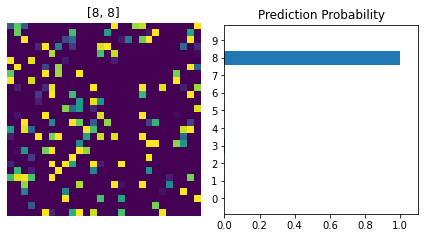

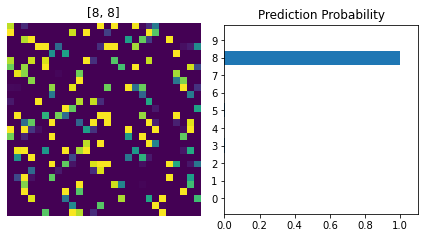

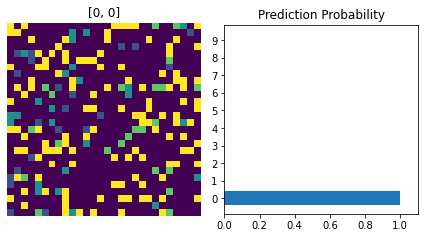

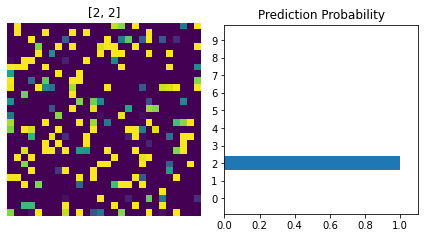

In [17]:
model_cnn_3.to('cpu') 

# fetch a batch of test images
image_batch, label_batch = next(iter(test_loader))
image_batch_scramble = image_batch.view(-1, 28*28)
image_batch_scramble = image_batch_scramble[:, fixed_perm]
image_batch_scramble = image_batch_scramble.view(-1, 1, 28, 28)
# Turn off gradients to speed up this part
with torch.no_grad():
    log_pred_prob_batch = model_cnn_3(image_batch_scramble)
for i in range(10):
    img = image_batch[i]
    img_perm = image_batch_scramble[i]
    real_label = label_batch[i].item()
    log_pred_prob = log_pred_prob_batch[i]
    # Output of the network are log-probabilities, need to take exponential for probabilities
    pred_prob = torch.exp(log_pred_prob).data.numpy().squeeze()
    visualize_pred(img_perm, pred_prob, real_label)